In [33]:
from bs4 import BeautifulSoup,Comment
import urllib.request
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
from sklearn import linear_model
from sklearn.cluster import KMeans
#from pandas import DataFrame as df

sns.set()

In [18]:
#to get soup for 2020 team offense using Comment, used below
url = "https://www.pro-football-reference.com/years/2020/"
soup = BeautifulSoup(requests.get(url).content, 'html.parser')
table = soup.select_one('#all_team_stats').find_next(text=lambda t: isinstance(t, Comment))
table = BeautifulSoup(table, 'html.parser')



In [19]:
#what the HTML looks like
table.prettify()[0:2500]

'<div class="table_container" id="div_team_stats">\n <table class="per_match_toggle sortable stats_table" data-cols-to-freeze=",2" id="team_stats">\n  <caption>\n   Team Offense Table\n  </caption>\n  <colgroup>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n  </colgroup>\n  <thead>\n   <tr class="over_header">\n    <th aria-label="" class="over_header center" colspan="2" data-stat="">\n    </th>\n    <th>\n    </th>\n    <th>\n    </th>\n    <th>\n    </th>\n    <th aria-label="" class="over_header center" colspan="3" data-stat="header_tot_off_tgl">\n     Tot Yds &amp; TO\n    </th>\n    <th>\n    </th>\n    <th>\n    </th>\n    <th aria-label="" class="over_header center" colspan="7" data-stat="header_pass">\n     Passing\n   

In [20]:
#function to rename columns to unique Offense/Defense data and columns that are missing titles from HTML table
def rename_cols(df):
    dict = {'Unnamed: 0_level_0':'TotOff',
            'Unnamed: 1_level_0':'TotOff',
            'Unnamed: 2_level_0':'TotOff',
            'Unnamed: 3_level_0':'TotOff',
            'Unnamed: 4_level_0':'TotOff',
            'Passing' : 'O_Passing',
            'Rushing' : 'O_Rushing',
            'Penalties': 'O_Penalties',
            'Tot Yds & TO':'TotOff',
            'Unnamed: 8_level_0':'TotOff',
            'Unnamed: 9_level_0':'TotOff',
            'Unnamed: 25_level_0':'O_Score%',
            'Unnamed: 26_level_0':'O_TurnOver%',
            'Unnamed: 27_level_0':'O_EXP',}
        
    # call rename() method
    df.rename(columns=dict,inplace=True)
    return(df)

def rename_cols_DEF(df):
    dict = {'Unnamed: 0_level_0':'TotDef',
            'Unnamed: 1_level_0':'TotDef',
            'Unnamed: 2_level_0':'TotDef',
            'Unnamed: 3_level_0':'TotDef',
            'Unnamed: 4_level_0':'TotDef',
            'Passing' : 'D_Passing',
            'Rushing' : 'D_Rushing',
            'Penalties': 'D_Penalties',
            'Tot Yds & TO':'TotDef',
            'Unnamed: 8_level_0':'TotDef',
            'Unnamed: 9_level_0':'TotDef',
            'Unnamed: 25_level_0':'D_Score%',
            'Unnamed: 26_level_0':'D_TurnOver%',
            'Unnamed: 27_level_0':'D_EXP',}
        
    # call rename() method
    df.rename(columns=dict,inplace=True)
    return(df)

In [21]:
#Get Team Offense Data
#for loop to get data for X years


year = 2020
#URL for website data
url = "https://www.pro-football-reference.com/years/"
urls = []
OFFdfs = []
for index in np.arange(10):
    #create URL for BeautifulSoup
    urls.append(url + str(year - index) +'/')
    years = year - index

count = 0
for index in urls:
    soup = BeautifulSoup(requests.get(index).content, 'html.parser')
    table = soup.select_one('#all_team_stats').find_next(text=lambda t: isinstance(t, Comment))
    table = BeautifulSoup(table, 'html.parser')    
    #create DF from html table, drop last 3 rows of data 
    OFFdf = pd.read_html(str(table))[0]
    curr_year = year - count
    OFFdf['Year'] = curr_year
    OFFdfs.append(OFFdf[:-3])
    count+=1


#initialize Master Team Offense Dataframe    
MasterOFF = OFFdfs[0]

for i in range(len(OFFdfs)-1):    
    #append DF to master, reset index to continuous
    MasterOFF = MasterOFF.append(OFFdfs[i+1],ignore_index = True)

#rename columns to useful index    
MasterOFF = rename_cols(MasterOFF)
#drop multi-index
MasterOFF.columns = ['_'.join(col) for col in MasterOFF.columns]
#cleanup Year column index
MasterOFF.rename(columns={'Year_':'Year'},inplace=True)

In [22]:
#Get Team Defense Data
#URL for website data
url = "https://www.pro-football-reference.com/years/"
urls = []
year = 2020
DEFdfs = []
ADV_DEFdf = []
Team_Sacks = pd.DataFrame(['Tm','Sk'])
for index in np.arange(10):
    #create URL for BeautifulSoup
    urls.append(url + str(year - index) +'/opp.htm')
    years = year - index

    
#mask for advanced_defense table data
sacks = ['Tm','Sk','Year']

#team_stats table does not include Sacks, so need passing table data and merge tables.
count = 0
for index in urls:
    curr_year = year - count
    soup = BeautifulSoup(requests.get(index).content, 'html.parser')
    table = soup.find('table', id = 'team_stats') 
    table2 = soup.select_one('#all_passing').find_next(text=lambda t: isinstance(t, Comment))
    table2 = BeautifulSoup(table2, 'html.parser')
    #create DF from html table, drop last 3 rows of data 
    DEFdf = pd.read_html(str(table))[0]
    DEFdf.drop(DEFdf.tail(3).index, inplace = True)
    #rename each DF
    rename_cols_DEF(DEFdf)
    #add year data
    DEFdf['Year'] = curr_year
    #drop multi-index
    DEFdf.columns = ['_'.join(col) for col in DEFdf.columns]
    
    ADV_DEFdf = pd.read_html(str(table2))[0]
    ADV_DEFdf.drop(ADV_DEFdf.tail(3).index,inplace = True)
    ADV_DEFdf['Year'] = curr_year
    #apply mask
    Team_Sacks = ADV_DEFdf[sacks].copy()
    #intermediate step prior to appending data. merges team_stats and team sacks data 
    DEFdf_interm = pd.merge(DEFdf,Team_Sacks, left_on =['TotDef_Tm'], right_on = ['Tm'] )
    #append to list of team defense data
   
    DEFdfs.append(DEFdf_interm)
    count+=1


#initialize master DataFrame with first list of Team Defense data
MasterDEF = DEFdfs[0]

for i in range(len(DEFdfs)-1):    
    #append DF to master, reset index to continuous
    MasterDEF = MasterDEF.append(DEFdfs[i+1],ignore_index = True)
    
MasterDEF.drop('Tm',axis = 1,inplace=True)
MasterDEF.drop('Year_',axis = 1,inplace=True)
MasterDEF.head(5)

,TotDef_Rk,TotDef_Tm,TotDef_G,TotDef_PF,TotDef_Yds,TotDef_Ply,TotDef_Y/P,TotDef_TO,TotDef_FL,TotDef_1stD,...,D_Rushing_Y/A,D_Rushing_1stD,D_Penalties_Pen,D_Penalties_Yds,D_Penalties_1stPy,D_Score%_Sc%,D_TurnOver%_TO%,D_EXP_EXP,Sk,Year
0,1.0,Los Angeles Rams,16.0,296.0,4511.0,989.0,4.6,22.0,8.0,280.0,...,3.8,91.0,78.0,582.0,19.0,27.9,12.0,85.89,53.0,2020
1,2.0,Baltimore Ravens,16.0,303.0,5276.0,1017.0,5.2,22.0,12.0,347.0,...,4.6,96.0,77.0,646.0,38.0,30.0,12.4,-17.69,39.0,2020
2,3.0,Pittsburgh Steelers,16.0,312.0,4893.0,996.0,4.9,27.0,9.0,281.0,...,4.3,94.0,103.0,980.0,24.0,29.3,13.8,33.24,56.0,2020
3,4.0,Washington Football Team,16.0,329.0,4873.0,1004.0,4.9,23.0,7.0,289.0,...,4.2,100.0,85.0,708.0,28.0,31.4,12.2,32.51,47.0,2020
4,5.0,New Orleans Saints,16.0,337.0,4974.0,992.0,5.0,26.0,8.0,320.0,...,3.9,85.0,64.0,517.0,50.0,34.7,13.1,-40.02,45.0,2020


In [23]:
#get standings inlcuding win-loss record

#for loop to get data for X years
year = 2020
#URL for website data
url = "https://www.pro-football-reference.com/years/"
urls = []
AFCStandDfs = []
NFCStandDfs = []
for index in np.arange(10):
    #create URL for BeautifulSoup
    urls.append(url + str(year - index) +'/')
    years = year - index

count = 0
for index in urls:
    soup = BeautifulSoup(requests.get(index).content, 'html.parser')
    #AFCtable = soup.select('table', id='AFC')
    #NFCtable = soup.select('table', id='NFC')
    AFCtable = soup.findAll('table', {'id':['AFC']})
    NFCtable = soup.findAll('table', {'id':['NFC']})
    AFCStandDf = pd.read_html(str(AFCtable))[0]
    NFCStandDf = pd.read_html(str(NFCtable))[0]
    curr_year = year - count
    AFCStandDf['Year'] = curr_year
    AFCStandDfs.append(AFCStandDf)
    NFCStandDf['Year'] = curr_year
    NFCStandDfs.append(NFCStandDf)    
    count+=1


#initialize Dataframe    
AFCStandings = AFCStandDfs[0]
NFCStandings = NFCStandDfs[0]
for i in range(len(AFCStandDfs)-1):    
    #append DF, reset index to continuous
    AFCStandings = AFCStandings.append(AFCStandDfs[i+1],ignore_index = True)
for i in range(len(NFCStandDfs)-1):
    NFCStandings = NFCStandings.append(NFCStandDfs[i+1],ignore_index = True)

#drop conference labels (north,east,west,south)    
AFCStandings.drop(AFCStandings.index[0:len(AFCStandings):5], inplace = True)
NFCStandings.drop(NFCStandings.index[0:len(NFCStandings):5], inplace = True)

#strip character marker
AFCStandings['Tm'] = AFCStandings['Tm'].str.rstrip('*'+'+')
NFCStandings['Tm'] = NFCStandings['Tm'].str.rstrip('*'+'+')

#combine standings
Standings = NFCStandings.append(AFCStandings)

Standings.drop(['MoV','SoS','SRS','OSRS','DSRS','PF','PA'],axis = 1,inplace = True)

#change object type to float
Standings['W'] = Standings['W'].astype(float)
Standings['L'] = Standings['L'].astype(float)
Standings['T'] = Standings['T'].astype(float)
Standings['W-L%'] = Standings['W-L%'].astype(float)
Standings['PD'] = Standings['PD'].astype(float)
Standings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 1 to 199
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Tm      320 non-null    object 
 1   W       320 non-null    float64
 2   L       320 non-null    float64
 3   T       224 non-null    float64
 4   W-L%    320 non-null    float64
 5   PD      320 non-null    float64
 6   Year    320 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 20.0+ KB


In [24]:
#get playoff results data
#includes winner and score

#for loop to get data for X years


year = 2020
#URL for website data
url = "https://www.pro-football-reference.com/years/"
urls = []
PlayOffdfs = []
for index in np.arange(10):
    #create URL for BeautifulSoup
    urls.append(url + str(year - index) +'/')
    years = year - index

count = 0
for index in urls:
    soup = BeautifulSoup(requests.get(index).content, 'html.parser')
    table = soup.select_one('#all_playoff_results').find_next(text=lambda t: isinstance(t, Comment))
    table = BeautifulSoup(table, 'html.parser') 
    PlayOffdf = pd.read_html(str(table))[0]
    curr_year = year - count
    PlayOffdf['Year'] = curr_year
    PlayOffdfs.append(PlayOffdf)
    count+=1


#initialize Playoffs Dataframe    
PlayOffs = PlayOffdfs[0]

for i in range(len(PlayOffdfs)-1):    
    #append DF, reset index to continuous
    PlayOffs = PlayOffs.append(PlayOffdfs[i+1],ignore_index = True)





In [25]:
PlayOffs.head(13)

,Week,Day,Date,Winner/tie,Unnamed: 4,Loser/tie,Unnamed: 6,Pts,Pts.1,Year
0,WildCard,Sat,2021-01-09,Buffalo Bills,NaN,Indianapolis Colts,boxscore,27,24,2020
1,WildCard,Sat,2021-01-09,Los Angeles Rams,@,Seattle Seahawks,boxscore,30,20,2020
2,WildCard,Sat,2021-01-09,Tampa Bay Buccaneers,@,Washington Football Team,boxscore,31,23,2020
3,WildCard,Sun,2021-01-10,Cleveland Browns,@,Pittsburgh Steelers,boxscore,48,37,2020
4,WildCard,Sun,2021-01-10,New Orleans Saints,NaN,Chicago Bears,boxscore,21,9,2020
5,WildCard,Sun,2021-01-10,Baltimore Ravens,@,Tennessee Titans,boxscore,20,13,2020
6,Division,Sat,2021-01-16,Green Bay Packers,NaN,Los Angeles Rams,boxscore,32,18,2020
7,Division,Sat,2021-01-16,Buffalo Bills,NaN,Baltimore Ravens,boxscore,17,3,2020
8,Division,Sun,2021-01-17,Kansas City Chiefs,NaN,Cleveland Browns,boxscore,22,17,2020
9,Division,Sun,2021-01-17,Tampa Bay Buccaneers,@,New Orleans Saints,boxscore,30,20,2020


In [26]:
PlayOffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Week        112 non-null    object
 1   Day         112 non-null    object
 2   Date        112 non-null    object
 3   Winner/tie  112 non-null    object
 4   Unnamed: 4  46 non-null     object
 5   Loser/tie   112 non-null    object
 6   Unnamed: 6  112 non-null    object
 7   Pts         112 non-null    int64 
 8   Pts.1       112 non-null    int64 
 9   Year        112 non-null    int64 
dtypes: int64(3), object(7)
memory usage: 8.9+ KB


In [27]:
PlayOffs.keys()

Index(['Week', 'Day', 'Date', 'Winner/tie', 'Unnamed: 4', 'Loser/tie',
       'Unnamed: 6', 'Pts', 'Pts.1', 'Year'],
      dtype='object')

In [28]:
SBWinner = PlayOffs.loc[PlayOffs['Week']=='SuperBowl']

In [29]:
SBWinner

,Week,Day,Date,Winner/tie,Unnamed: 4,Loser/tie,Unnamed: 6,Pts,Pts.1,Year
12,SuperBowl,Sun,2021-02-07,Tampa Bay Buccaneers,N,Kansas City Chiefs,boxscore,31,9,2020
23,SuperBowl,Sun,2020-02-02,Kansas City Chiefs,N,San Francisco 49ers,boxscore,31,20,2019
34,SuperBowl,Sun,2019-02-03,New England Patriots,N,Los Angeles Rams,boxscore,13,3,2018
45,SuperBowl,Sun,2018-02-04,Philadelphia Eagles,N,New England Patriots,boxscore,41,33,2017
56,SuperBowl,Sun,2017-02-05,New England Patriots,N,Atlanta Falcons,boxscore,34,28,2016
67,SuperBowl,Sun,2016-02-07,Denver Broncos,N,Carolina Panthers,boxscore,24,10,2015
78,SuperBowl,Sun,2015-02-01,New England Patriots,N,Seattle Seahawks,boxscore,28,24,2014
89,SuperBowl,Sun,2014-02-02,Seattle Seahawks,N,Denver Broncos,boxscore,43,8,2013
100,SuperBowl,Sun,2013-02-03,Baltimore Ravens,N,San Francisco 49ers,boxscore,34,31,2012
111,SuperBowl,Sun,2012-02-05,New York Giants,N,New England Patriots,boxscore,21,17,2011


In [30]:
#assigning binary superbowl win column to master team offense dataframe.
#this block should be put into a for loop

MasterOFF[('SB_Win')] = 0

row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'Tampa Bay Buccaneers') & (MasterOFF['Year'] == 2020)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'Kansas City Chiefs') & (MasterOFF['Year'] == 2019)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'New England Patriots') & (MasterOFF['Year'] == 2018)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'Philadelphia Eagles') & (MasterOFF['Year'] == 2017)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'New England Patriots') & (MasterOFF['Year'] == 2016)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'Denver Broncos') & (MasterOFF['Year'] == 2015)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'New England Patriots') & (MasterOFF['Year'] == 2014)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'Seattle Seahawks') & (MasterOFF['Year'] == 2013)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'Baltimore Ravens') & (MasterOFF['Year'] == 2012)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'New York Giants') & (MasterOFF['Year'] == 2011)].index
MasterOFF.at[row[0],('SB_Win')] = 1


MasterOFF.head(5)


,TotOff_Rk,TotOff_Tm,TotOff_G,TotOff_PF,TotOff_Yds,TotOff_Ply,TotOff_Y/P,TotOff_TO,TotOff_FL,TotOff_1stD,...,O_Rushing_Y/A,O_Rushing_1stD,O_Penalties_Pen,O_Penalties_Yds,O_Penalties_1stPy,O_Score%_Sc%,O_TurnOver%_TO%,O_EXP_EXP,Year,SB_Win
0,1.0,Green Bay Packers,16.0,509.0,6224.0,990.0,6.3,11.0,6.0,358.0,...,4.8,114.0,84.0,684.0,28.0,49.7,5.6,290.75,2020,0
1,2.0,Buffalo Bills,16.0,501.0,6343.0,1034.0,6.1,22.0,11.0,397.0,...,4.2,119.0,102.0,941.0,38.0,49.4,11.8,228.66,2020,0
2,3.0,Tampa Bay Buccaneers,16.0,492.0,6145.0,1017.0,6.0,17.0,5.0,364.0,...,4.1,82.0,84.0,715.0,44.0,47.8,8.9,246.24,2020,1
3,4.0,Tennessee Titans,16.0,491.0,6343.0,1031.0,6.2,12.0,5.0,381.0,...,5.2,142.0,86.0,783.0,36.0,47.9,7.2,245.01,2020,0
4,5.0,New Orleans Saints,16.0,482.0,6023.0,1045.0,5.8,17.0,9.0,367.0,...,4.6,147.0,98.0,1005.0,21.0,45.5,9.0,176.94,2020,0


In [31]:
#Year = MasterOFF['Year'] == 2020
Year = SBWinner['Year'] == 2020

SBWinner.loc[Year]['Winner/tie']

12    Tampa Bay Buccaneers
Name: Winner/tie, dtype: object

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


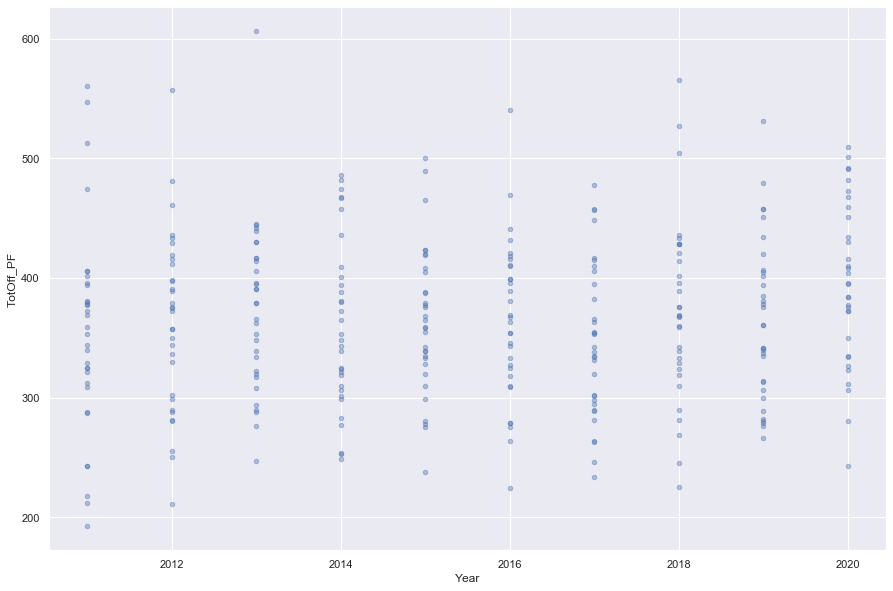

In [34]:
#scatter plot of total offense points scored vs year
MasterOFFcopy = MasterOFF
MasterOFFcopy.plot.scatter("Year", "TotOff_PF", figsize=(15, 10), alpha=0.4)

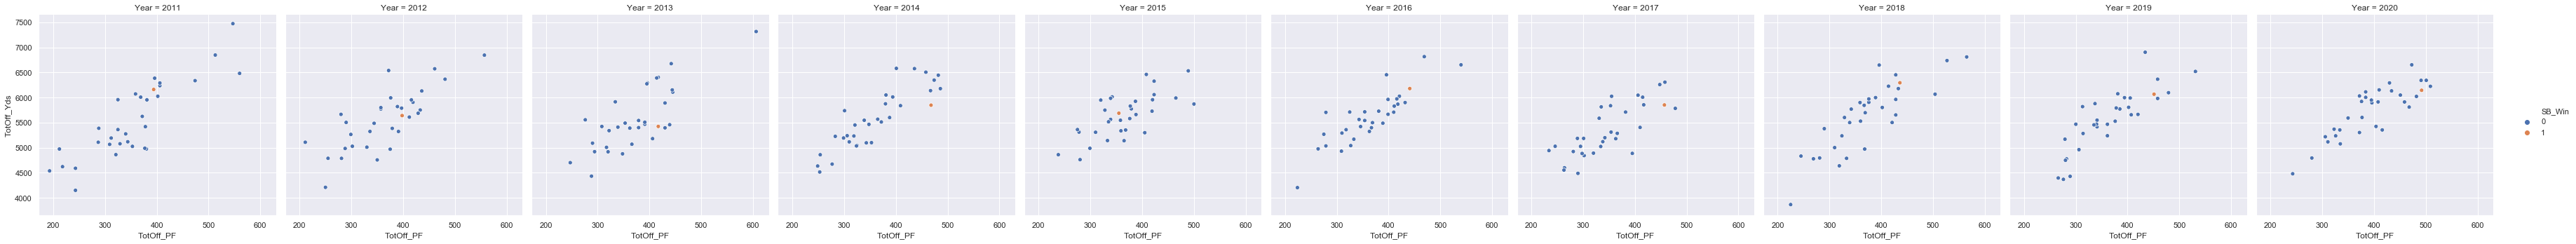

In [35]:
#relationship plot

sns.relplot(
    data=MasterOFFcopy,
    x="TotOff_PF", y="TotOff_Yds", col="Year", hue="SB_Win")

In [36]:
MasterOFFcopy.corr()

,TotOff_Rk,TotOff_G,TotOff_PF,TotOff_Yds,TotOff_Ply,TotOff_Y/P,TotOff_TO,TotOff_FL,TotOff_1stD,O_Passing_Cmp,...,O_Rushing_Y/A,O_Rushing_1stD,O_Penalties_Pen,O_Penalties_Yds,O_Penalties_1stPy,O_Score%_Sc%,O_TurnOver%_TO%,O_EXP_EXP,Year,SB_Win
TotOff_Rk,1.000000,NaN,-0.948508,-0.781203,-0.345740,-0.752689,0.439222,0.252628,-0.725953,-0.330179,...,-0.264700,-0.437622,0.041428,0.028976,-0.189373,-0.836639,0.443096,-0.688925,0.000000,-0.186743
TotOff_G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TotOff_PF,-0.948508,NaN,1.000000,0.820086,0.377085,0.780439,-0.423991,-0.237777,0.792417,0.392479,...,0.273545,0.457457,-0.077126,-0.053769,0.192259,0.889548,-0.424879,0.779519,0.082008,0.162349
TotOff_Yds,-0.781203,NaN,0.820086,1.000000,0.566441,0.898762,-0.220319,-0.107549,0.905728,0.571572,...,0.293057,0.416505,0.003388,0.024067,0.141288,0.782992,-0.192359,0.736869,0.042168,0.107652
TotOff_Ply,-0.345740,NaN,0.377085,0.566441,1.000000,0.152868,0.081489,0.078546,0.655020,0.526112,...,-0.144748,0.240322,-0.057434,-0.041267,0.210367,0.286234,0.025457,0.253900,-0.067620,0.052439
TotOff_Y/P,-0.752689,NaN,0.780439,0.898762,0.152868,1.000000,-0.311091,-0.173023,0.737937,0.403626,...,0.434702,0.377274,0.032499,0.050726,0.059594,0.789447,-0.247937,0.747503,0.094574,0.107995
TotOff_TO,0.439222,NaN,-0.423991,-0.220319,0.081489,-0.311091,1.000000,0.659264,-0.235801,-0.035575,...,-0.189763,-0.308842,0.041473,0.017177,-0.056727,-0.545312,0.959604,-0.494071,-0.234925,-0.136055
TotOff_FL,0.252628,NaN,-0.237777,-0.107549,0.078546,-0.173023,0.659264,1.000000,-0.110853,-0.044890,...,-0.056379,-0.114253,-0.003523,-0.023674,-0.049767,-0.320786,0.596685,-0.253089,-0.134337,-0.088234
TotOff_1stD,-0.725953,NaN,0.792417,0.905728,0.655020,0.737937,-0.235801,-0.110853,1.000000,0.613553,...,0.204405,0.469483,-0.140158,-0.114214,0.337459,0.791199,-0.182924,0.765578,0.180570,0.087495
O_Passing_Cmp,-0.330179,NaN,0.392479,0.571572,0.526112,0.403626,-0.035575,-0.044890,0.613553,1.000000,...,-0.271144,-0.254437,-0.033635,-0.004714,0.168006,0.408298,-0.009531,0.434515,0.187359,0.036310


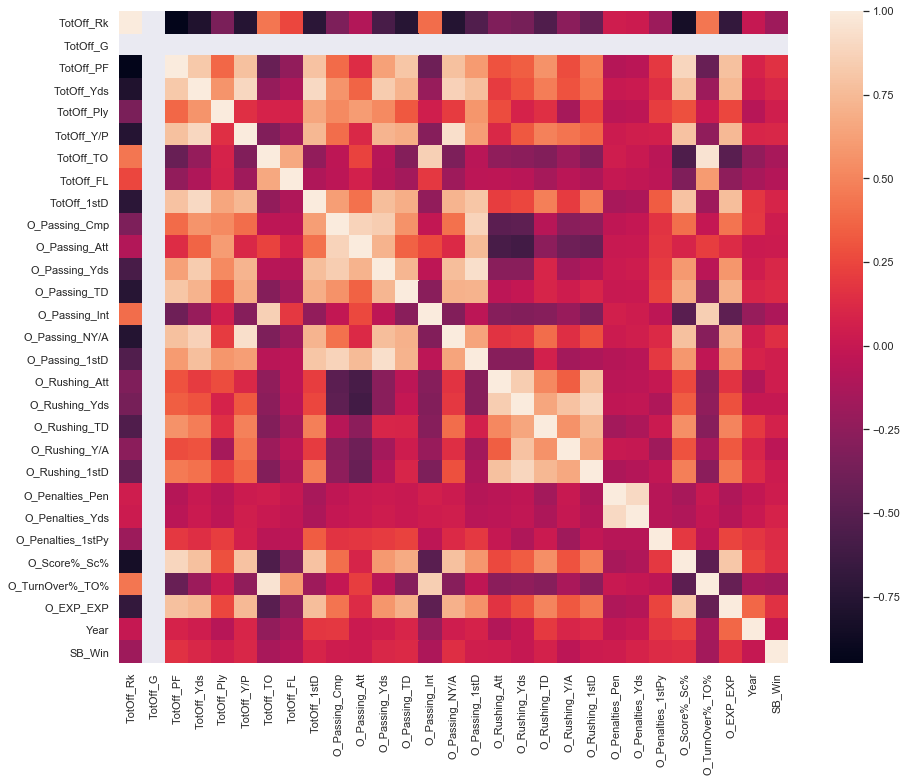

In [37]:
Var_Corr = MasterOFFcopy.corr()
# plot the heatmap and annotation on it
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, ax = ax)

In [38]:
#Combine Offense and Defense Dataframes
DF_OFF_DEF = pd.merge(MasterOFF,MasterDEF, left_on =['TotOff_Tm','Year'], right_on = ['TotDef_Tm','Year'], how = 'left' )


In [39]:
DF_OFF_DEF.head(5)

,TotOff_Rk,TotOff_Tm,TotOff_G,TotOff_PF,TotOff_Yds,TotOff_Ply,TotOff_Y/P,TotOff_TO,TotOff_FL,TotOff_1stD,...,D_Rushing_TD,D_Rushing_Y/A,D_Rushing_1stD,D_Penalties_Pen,D_Penalties_Yds,D_Penalties_1stPy,D_Score%_Sc%,D_TurnOver%_TO%,D_EXP_EXP,Sk
0,1.0,Green Bay Packers,16.0,509.0,6224.0,990.0,6.3,11.0,6.0,358.0,...,16.0,4.5,119.0,79.0,734.0,29.0,39.9,11.4,-109.67,41.0
1,2.0,Buffalo Bills,16.0,501.0,6343.0,1034.0,6.1,22.0,11.0,397.0,...,21.0,4.6,125.0,86.0,728.0,27.0,39.4,15.3,-123.10,38.0
2,3.0,Tampa Bay Buccaneers,16.0,492.0,6145.0,1017.0,6.0,17.0,5.0,364.0,...,10.0,3.6,78.0,95.0,1015.0,26.0,33.7,14.0,-22.04,48.0
3,4.0,Tennessee Titans,16.0,491.0,6343.0,1031.0,6.2,12.0,5.0,381.0,...,18.0,4.5,113.0,103.0,840.0,31.0,45.2,13.3,-185.20,19.0
4,5.0,New Orleans Saints,16.0,482.0,6023.0,1045.0,5.8,17.0,9.0,367.0,...,11.0,3.9,85.0,64.0,517.0,50.0,34.7,13.1,-40.02,45.0


In [40]:
DF_OFF_DEF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 0 to 319
Data columns (total 59 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TotOff_Rk          320 non-null    float64
 1   TotOff_Tm          320 non-null    object 
 2   TotOff_G           320 non-null    float64
 3   TotOff_PF          320 non-null    float64
 4   TotOff_Yds         320 non-null    float64
 5   TotOff_Ply         320 non-null    float64
 6   TotOff_Y/P         320 non-null    float64
 7   TotOff_TO          320 non-null    float64
 8   TotOff_FL          320 non-null    float64
 9   TotOff_1stD        320 non-null    float64
 10  O_Passing_Cmp      320 non-null    float64
 11  O_Passing_Att      320 non-null    float64
 12  O_Passing_Yds      320 non-null    float64
 13  O_Passing_TD       320 non-null    float64
 14  O_Passing_Int      320 non-null    float64
 15  O_Passing_NY/A     320 non-null    float64
 16  O_Passing_1stD     320 non

In [41]:
#merge offense, defense, and standings data
DF= pd.merge(DF_OFF_DEF,Standings, left_on =['TotOff_Tm','Year'], right_on = ['Tm','Year'])
DF.drop(['TotOff_Tm','TotDef_Tm','TotOff_G','TotDef_G'],axis = 1,inplace = True)

In [42]:
SB_all_ols = sm.ols(formula="SB_Win ~ TotOff_PF+TotOff_Yds+TotOff_Ply+TotOff_TO+TotOff_FL+TotDef_PF+TotDef_Yds+TotDef_Ply+TotDef_TO+TotDef_FL+Sk+W-L%", data=DF).fit()
SB_all_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SB_Win   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     1.671
Date:                Sun, 25 Apr 2021   Prob (F-statistic):             0.0723
Time:                        15:03:08   Log-Likelihood:                 115.66
No. Observations:                 320   AIC:                            -205.3
Df Residuals:                     307   BIC:                            -156.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3161      0.365     -0.866      0.387      -1.035       0.403
TotOff_PF  -3.035e-05      0.000     -0.075      0.940      -0.001       0.001
TotOff_Yds  2.735e-05      4e-05      0.683      0.495   -5.14e-05       0.000
TotOff_Ply -4.148e-05      0.000     -0.152      0.879      -0.001       0.000
TotOff_TO     -0.0020      0.003     -0.771      0.441      -0.007       0.003
TotOff_FL  -2.553e-05      0.004     -0.006      0.995      -0.008       0.008
TotDef_PF   5.379e-05      0.000      0.133      0.894      -0.001       0.001
TotDef_Yds -6.151e-05   4.06e-05     -1.515      0.131      -0.000    1.84e-05
TotDef_Ply     0.0006      0.000      1.804      0.072   -5.04e-05       0.001
TotDef_TO      0.0019      0.003      0.703      0.483      -0.003       0.007
TotDef_FL     -0.0015      0.004     -0.343      0.732      -0.010       0.007
Sk            -0.0007      0.001     -0.471      0.638      -0.004       0.002
W              0.0057      0.008      0.727      0.468      -0.010       0.021
==============================================================================
Omnibus:                      341.847   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8671.481
Skew:                           4.876   Prob(JB):                         0.00
Kurtosis:                      26.564   Cond. No.                     3.06e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.06e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

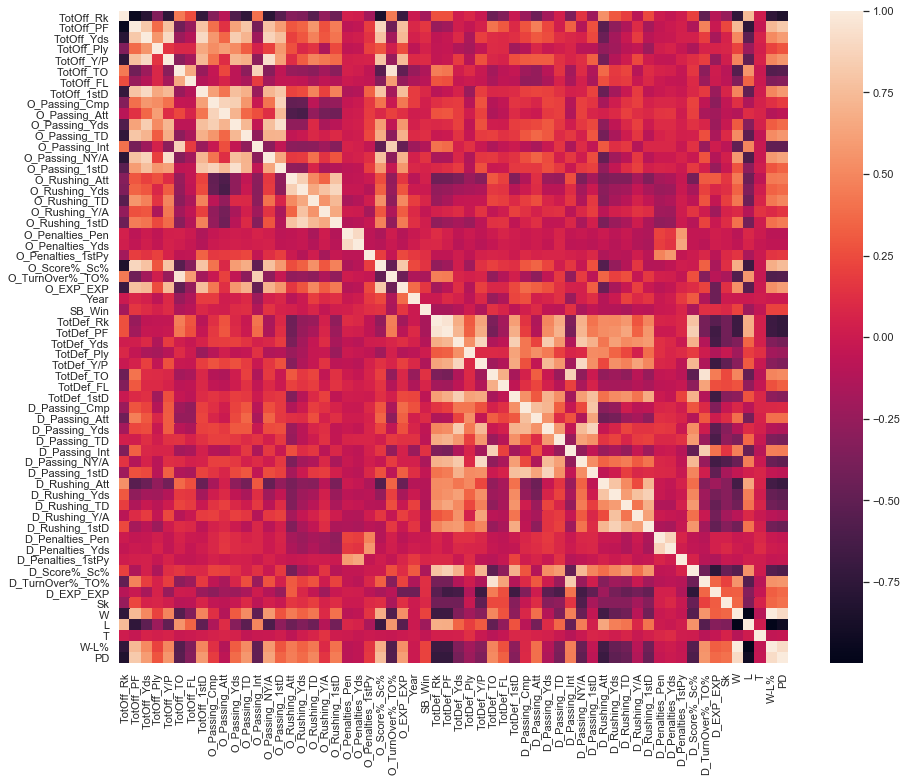

In [43]:
Var_Corr = DF.corr()
# plot the heatmap and annotation on it
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, ax = ax)

In [44]:
print(DF.keys())

Index(['TotOff_Rk', 'TotOff_PF', 'TotOff_Yds', 'TotOff_Ply', 'TotOff_Y/P',
       'TotOff_TO', 'TotOff_FL', 'TotOff_1stD', 'O_Passing_Cmp',
       'O_Passing_Att', 'O_Passing_Yds', 'O_Passing_TD', 'O_Passing_Int',
       'O_Passing_NY/A', 'O_Passing_1stD', 'O_Rushing_Att', 'O_Rushing_Yds',
       'O_Rushing_TD', 'O_Rushing_Y/A', 'O_Rushing_1stD', 'O_Penalties_Pen',
       'O_Penalties_Yds', 'O_Penalties_1stPy', 'O_Score%_Sc%',
       'O_TurnOver%_TO%', 'O_EXP_EXP', 'Year', 'SB_Win', 'TotDef_Rk',
       'TotDef_PF', 'TotDef_Yds', 'TotDef_Ply', 'TotDef_Y/P', 'TotDef_TO',
       'TotDef_FL', 'TotDef_1stD', 'D_Passing_Cmp', 'D_Passing_Att',
       'D_Passing_Yds', 'D_Passing_TD', 'D_Passing_Int', 'D_Passing_NY/A',
       'D_Passing_1stD', 'D_Rushing_Att', 'D_Rushing_Yds', 'D_Rushing_TD',
       'D_Rushing_Y/A', 'D_Rushing_1stD', 'D_Penalties_Pen', 'D_Penalties_Yds',
       'D_Penalties_1stPy', 'D_Score%_Sc%', 'D_TurnOver%_TO%', 'D_EXP_EXP',
       'Sk', 'Tm', 'W', 'L', 'T', 'W-L%', 'PD'],


In [45]:
SB_all_ols = sm.ols(formula=
        "SB_Win ~ Year+D_Passing_Int+D_Passing_TD+D_Passing_Yds+D_Passing_Att+D_Passing_Cmp+O_Rushing_TD+O_Rushing_Yds+O_Rushing_Att+O_Passing_Int+O_Passing_TD+O_Passing_Yds+O_Passing_Att+O_Passing_Cmp+TotOff_PF+TotOff_Yds+TotOff_Ply+TotOff_TO+TotOff_FL+TotDef_PF+TotDef_Yds+TotDef_Ply+TotDef_TO+TotDef_FL+Sk+W-L%", data=DF).fit()
SB_all_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SB_Win   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1.373
Date:                Sun, 25 Apr 2021   Prob (F-statistic):              0.121
Time:                        15:03:13   Log-Likelihood:                 121.76
No. Observations:                 320   AIC:                            -195.5
Df Residuals:                     296   BIC:                            -105.1
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.6414      8.860     -0.298      0.766     -20.078      14.796
Year              0.0013      0.004      0.290      0.772      -0.007       0.010
D_Passing_Int     0.0010      0.002      0.461      0.645      -0.003       0.005
D_Passing_TD      0.0037      0.003      1.347      0.179      -0.002       0.009
D_Passing_Yds -3.407e-05   8.68e-05     -0.393      0.695      -0.000       0.000
D_Passing_Att    -0.0008      0.001     -1.129      0.260      -0.002       0.001
D_Passing_Cmp     0.0009      0.001      1.205      0.229      -0.001       0.002
O_Rushing_TD      0.0013      0.004      0.303      0.762      -0.007       0.010
O_Rushing_Yds -5.935e-05   4.92e-05     -1.206      0.229      -0.000    3.75e-05
O_Rushing_Att     0.0005      0.001      0.372      0.710      -0.002       0.003
O_Passing_Int    -0.0025      0.002     -1.166      0.244      -0.007       0.002
O_Passing_TD   1.637e-05      0.004      0.004      0.996      -0.007       0.007
O_Passing_Yds  6.341e-05   3.54e-05      1.791      0.074   -6.25e-06       0.000
O_Passing_Att     0.0013      0.001      1.010      0.313      -0.001       0.004
O_Passing_Cmp    -0.0016      0.001     -2.280      0.023      -0.003      -0.000
TotOff_PF         0.0001      0.001      0.185      0.853      -0.001       0.001
TotOff_Yds      4.06e-06   3.33e-05      0.122      0.903   -6.15e-05    6.96e-05
TotOff_Ply       -0.0005      0.001     -0.413      0.680      -0.003       0.002
TotOff_TO        -0.0016      0.002     -1.015      0.311      -0.005       0.002
TotOff_FL         0.0008      0.002      0.344      0.731      -0.004       0.006
TotDef_PF        -0.0003      0.000     -0.664      0.507      -0.001       0.001
TotDef_Yds    -5.554e-05   6.86e-05     -0.810      0.419      -0.000    7.94e-05
TotDef_Ply        0.0007      0.001      1.371      0.171      -0.000       0.002
TotDef_TO         0.0007      0.002      0.444      0.657      -0.002       0.004
TotDef_FL        -0.0003      0.003     -0.123      0.902      -0.005       0.005
Sk               -0.0014      0.002     -0.880      0.380      -0.004       0.002
W                 0.0085      0.008      1.039      0.300      -0.008       0.025
==============================================================================
Omnibus:                      327.303   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7439.880
Skew:                           4.592   Prob(JB):                         0.00
Kurtosis:                      24.764   Cond. No.                     1.00e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.24e-22. This 

In [46]:
# Create new DF without the 2020 season 
mask = DF['Year'] != 2020
DF_pre20 = DF[mask]
DF_pre20.columns

Index(['TotOff_Rk', 'TotOff_PF', 'TotOff_Yds', 'TotOff_Ply', 'TotOff_Y/P',
       'TotOff_TO', 'TotOff_FL', 'TotOff_1stD', 'O_Passing_Cmp',
       'O_Passing_Att', 'O_Passing_Yds', 'O_Passing_TD', 'O_Passing_Int',
       'O_Passing_NY/A', 'O_Passing_1stD', 'O_Rushing_Att', 'O_Rushing_Yds',
       'O_Rushing_TD', 'O_Rushing_Y/A', 'O_Rushing_1stD', 'O_Penalties_Pen',
       'O_Penalties_Yds', 'O_Penalties_1stPy', 'O_Score%_Sc%',
       'O_TurnOver%_TO%', 'O_EXP_EXP', 'Year', 'SB_Win', 'TotDef_Rk',
       'TotDef_PF', 'TotDef_Yds', 'TotDef_Ply', 'TotDef_Y/P', 'TotDef_TO',
       'TotDef_FL', 'TotDef_1stD', 'D_Passing_Cmp', 'D_Passing_Att',
       'D_Passing_Yds', 'D_Passing_TD', 'D_Passing_Int', 'D_Passing_NY/A',
       'D_Passing_1stD', 'D_Rushing_Att', 'D_Rushing_Yds', 'D_Rushing_TD',
       'D_Rushing_Y/A', 'D_Rushing_1stD', 'D_Penalties_Pen', 'D_Penalties_Yds',
       'D_Penalties_1stPy', 'D_Score%_Sc%', 'D_TurnOver%_TO%', 'D_EXP_EXP',
       'Sk', 'Tm', 'W', 'L', 'T', 'W-L%', 'PD'],


In [51]:
y_logit_train = DF_pre20['SB_Win']
print(y_logit_train)

32     0
33     0
34     0
35     0
36     1
      ..
315    0
316    0
317    0
318    0
319    0
Name: SB_Win, Length: 288, dtype: int64


In [52]:
X_logit_train = DF_pre20.drop(columns=['SB_Win'])
y_logit_train = DF_pre20['SB_Win']
X_logit_train2 = X_logit_train
offense_vars = []
defense_vars = ['Sk']
for col in X_logit_train2.columns:
    if 'O_' in col or 'Off' in col:
        offense_vars.append(col)
    if 'D_' in col or 'Def' in col:
        defense_vars.append(col)
off_cols_string = ' + '.join(offense_vars)
formula_string = 'SB_Win ~ ' + off_cols_string
current_off_cols = []
for col in offense_vars:
    current_off_cols.append(col)
    try:
        off_logit_model = sm.logit(y_logit_train, X_logit_train2[current_off_cols]).fit(maxiter=10000,disp=0)
    except np.linalg.LinAlgError:
        current_off_cols = current_off_cols[0:-1]
        print(col+' results in a singular matrix and was dropped')
        continue

off_logit_model.summary()
        
        
# current_def_cols = []
# for col in defense_vars:
#     current_def_cols.append(col)
#     try:
#         def_logit_model = sm.Logit(y_logit_train, X_logit_train2[current_def_cols]).fit(maxiter=10000, disp=0)
#     except np.linalg.LinAlgError:
#         current_def_cols = current_def_cols[0:-1]
#         print(col+' results in a singular matrix and was dropped')
#         continue

AttributeError: module 'statsmodels.formula.api' has no attribute 'Logit'

In [ ]:
no_nan_col = []
for i, p_value in enumerate(off_logit_model.pvalues):
    if np.isnan(p_value):
        continue
    else:
        no_nan_col.append(current_off_cols[i])

off_logit_model_2 = sm.Logit(y_logit_train, X_logit_train2[no_nan_col]).fit(maxiter=10000)
off_logit_model_2.summary()

# print(np.argmax(off_logit_model_2.pvalues))
max_pval_index = np.argmax(off_logit_model_2.pvalues)
print(no_nan_col[max_pval_index])
no_nan_col2 = no_nan_col[0:max_pval_index]+no_nan_col[max_pval_index+1:]
print(no_nan_col2)
off_logit_model_2 = sm.Logit(y_logit_train, X_logit_train2[no_nan_col2]).fit(maxiter=10000)
off_logit_model_2.summary()
# off_logit_model_2.summary()

    


In [ ]:
type(no_nan_col2)

In [57]:
X_logit_train = DF_pre20.drop(columns=['SB_Win'])
y_logit_train = DF_pre20['SB_Win']
X_logit_train2 = X_logit_train
offense_vars = []
defense_vars = ['Sk']
for col in X_logit_train2.columns:
    if 'O_' in col or 'Off' in col:
        offense_vars.append(col)
    if 'D_' in col or 'Def' in col:
        defense_vars.append(col)
off_cols_string = ' + '.join(offense_vars)
formula_string = 'SB_Win ~ ' + off_cols_string

logit_model = sm.logit(formula_string, DF_pre20)

SyntaxError: invalid syntax (<unknown>, line 1)